The code in this notebook was used for [Kaggle's House Prices Competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques). LRH 12APR18

#### Setup

In [1]:
# %matplotlib inline
import csv
import numpy as np
import pandas as pd
import statsmodels
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestRegressor

I wrote this little fullprint function so Jupyter will show me ALL of the columns and ALL of the rows in a dataframe. If you don't have something like this, Jupyter truncates the output and will only show you the beginning and end columns/data. Note that if you're worried about a full dataset blowing up your screen, Jupyter contrains output to an inner box.

In [2]:
def fullprint(df):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display(df)

For this competition, Kaggle provides two datasets: One called Train, which INCLUDES values for SalePrice, and one called Test, which DOES NOT INCLUDE values for SalePrice. You build the model as best as you can using Train, then use that to predict SalePrice for Test. Your submission to Kaggle will include the Id in Test, as well as your predicted SalePrices.

In [3]:
train = pd.read_csv('C:\\Users\\laure\\Desktop\\Jupyter\\Housing\\train.csv')

#### Exploration

Take a peek at the data:

In [4]:
fullprint(train)

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1          60       RL         65.0     8450   Pave   NaN      Reg   
1        2          20       RL         80.0     9600   Pave   NaN      Reg   
2        3          60       RL         68.0    11250   Pave   NaN      IR1   
3        4          70       RL         60.0     9550   Pave   NaN      IR1   
4        5          60       RL         84.0    14260   Pave   NaN      IR1   
5        6          50       RL         85.0    14115   Pave   NaN      IR1   
6        7          20       RL         75.0    10084   Pave   NaN      Reg   
7        8          60       RL          NaN    10382   Pave   NaN      IR1   
8        9          50       RM         51.0     6120   Pave   NaN      Reg   
9       10         190       RL         50.0     7420   Pave   NaN      Reg   
10      11          20       RL         70.0    11200   Pave   NaN      Reg   
11      12          60       RL         85.0    11924   Pave   NaN      IR1   
12      13          20       RL          NaN    12968   Pave   NaN      IR2   
13      14          20       RL         91.0    10652   Pave   NaN      IR1   
14      15          20       RL          NaN    10920   Pave   NaN      IR1   
15      16          45       RM         51.0     6120   Pave   NaN      Reg   
16      17          20       RL          NaN    11241   Pave   NaN      IR1   
17      18          90       RL         72.0    10791   Pave   NaN      Reg   
18      19          20       RL         66.0    13695   Pave   NaN      Reg   
19      20          20       RL         70.0     7560   Pave   NaN      Reg   
20      21          60       RL        101.0    14215   Pave   NaN      IR1   
21      22          45       RM         57.0     7449   Pave  Grvl      Reg   
22      23          20       RL         75.0     9742   Pave   NaN      Reg   
23      24         120       RM         44.0     4224   Pave   NaN      Reg   
24      25          20       RL          NaN     8246   Pave   NaN      IR1   
25      26          20       RL        110.0    14230   Pave   NaN      Reg   
26      27          20       RL         60.0     7200   Pave   NaN      Reg   
27      28          20       RL         98.0    11478   Pave   NaN      Reg   
28      29          20       RL         47.0    16321   Pave   NaN      IR1   
29      30          30       RM         60.0     6324   Pave   NaN      IR1   
30      31          70  C (all)         50.0     8500   Pave  Pave      Reg   
31      32          20       RL          NaN     8544   Pave   NaN      IR1   
32      33          20       RL         85.0    11049   Pave   NaN      Reg   
33      34          20       RL         70.0    10552   Pave   NaN      IR1   
34      35         120       RL         60.0     7313   Pave   NaN      Reg   
35      36          60       RL        108.0    13418   Pave   NaN      Reg   
36      37          20       RL        112.0    10859   Pave   NaN      Reg   
37      38          20       RL         74.0     8532   Pave   NaN      Reg   
38      39          20       RL         68.0     7922   Pave   NaN      Reg   
39      40          90       RL         65.0     6040   Pave   NaN      Reg   
40      41          20       RL         84.0     8658   Pave   NaN      Reg   
41      42          20       RL        115.0    16905   Pave   NaN      Reg   
42      43          85       RL          NaN     9180   Pave   NaN      IR1   
43      44          20       RL          NaN     9200   Pave   NaN      IR1   
44      45          20       RL         70.0     7945   Pave   NaN      Reg   
45      46         120       RL         61.0     7658   Pave   NaN      Reg   
46      47          50       RL         48.0    12822   Pave   NaN      IR1   
47      48          20       FV         84.0    11096   Pave   NaN      Reg   
48      49         190       RM         33.0     4456   Pave   NaN      Reg   
49      50          20       RL         66.0     7742   Pa

Histogram of SalePrice values:

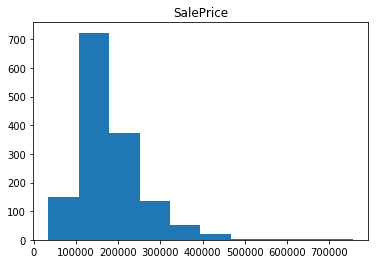

In [5]:
n = plt.hist(train['SalePrice'])
plt.title('SalePrice')
plt.show()

Pulled the categorical variable names by looking at [Kaggle's data documentation](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data). Removed Exterior2nd from later processing based on VIF results - multicollinearity with Exterior1st.

In [6]:
categors = ['MSSubClass','MSZoning','Street','Alley','LotShape','LandContour','Utilities','LotConfig',
           'LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle',
           'OverallQual','OverallCond','RoofStyle','RoofMatl','Exterior1st','Exterior2nd',
           'MasVnrType','ExterQual','ExterCond','Foundation','BsmtQual','BsmtCond','BsmtExposure',
           'BsmtFinType1','BsmtFinType2','Heating','HeatingQC','CentralAir','Electrical',
           'KitchenQual','Functional','FireplaceQu','GarageType','GarageFinish','GarageQual',
           'GarageCond','PavedDrive','PoolQC','Fence','MiscFeature','SaleType','SaleCondition']

numers will contain all of the variables in train that are not listed in categors.

In [7]:
numers=[i for i in train if i not in categors]

Null values in Python show up as NaN. For the categorical variables, we'll tell Python to use MISSING, and 0 for the numeric variables.

In [8]:
for i,col in enumerate(categors):
    train[col] = train[col].replace(np.nan,'MISSING')
    
for i,col in enumerate(numers):
    train[col] = train[col].replace(np.nan,0)

The swarmplots below for each categorical variable take a long time to run. Unless you change something fundamental prior to this point with the data, I would recommend running this once and then commenting out the code for future runs. You can quickly comment out / uncomment a line of code in Python with Ctrl + /.

Pyplot will throw an error about memory.

C:\Users\laure\Anaconda3\lib\site-packages\matplotlib\pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


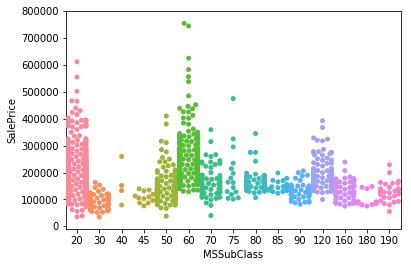

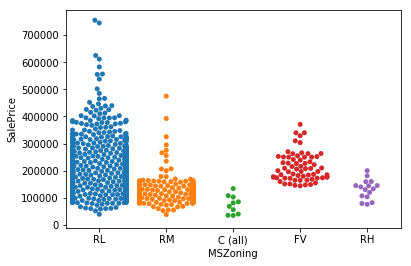

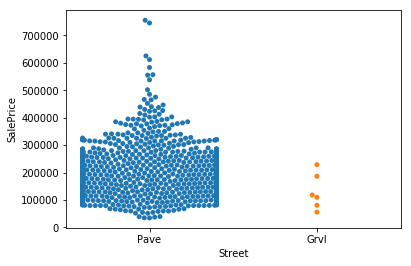

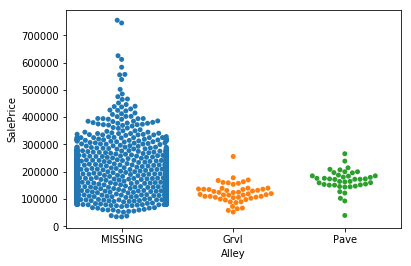

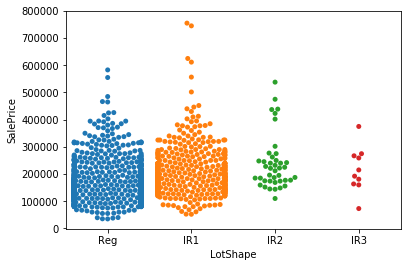

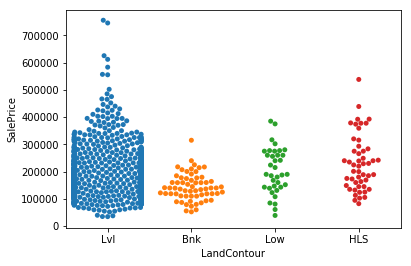

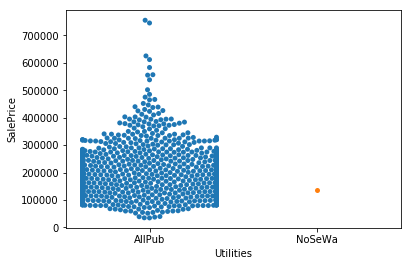

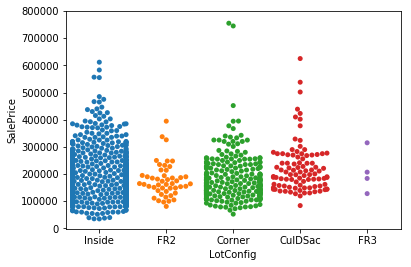

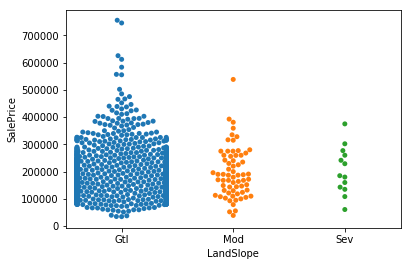

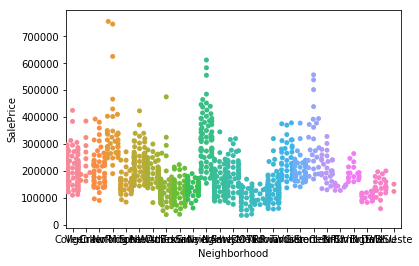

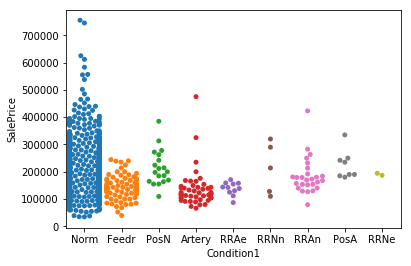

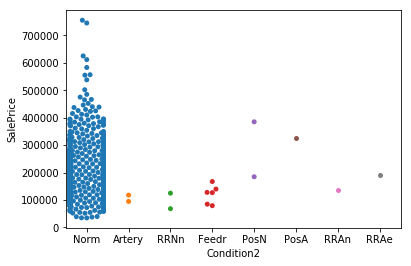

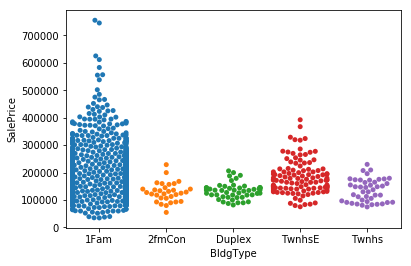

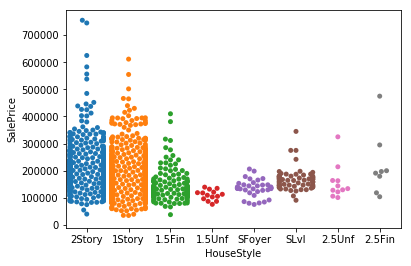

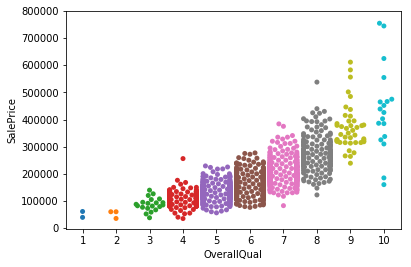

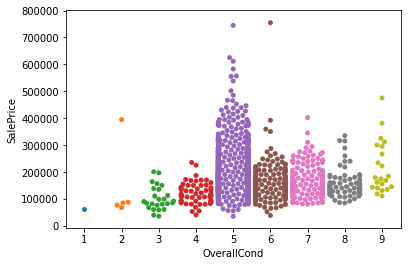

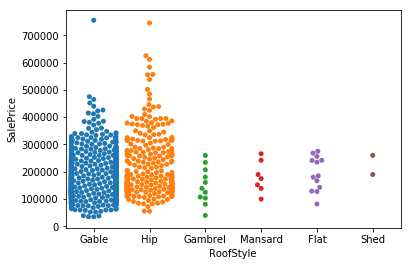

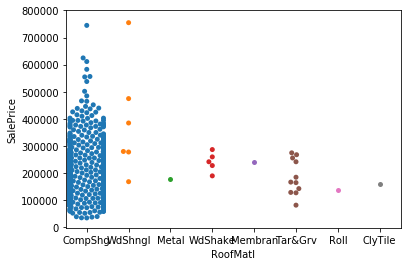

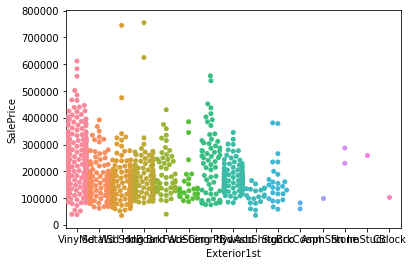

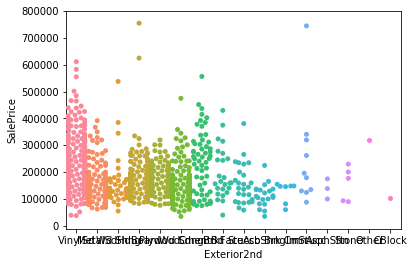

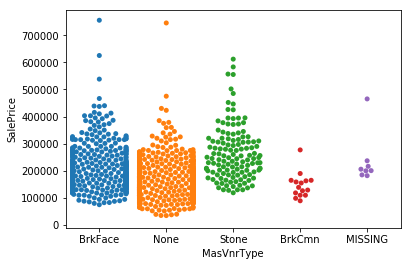

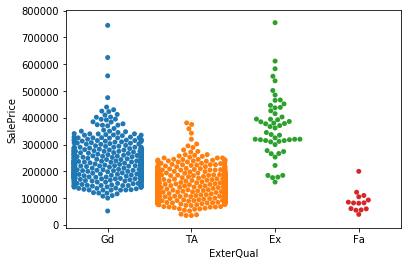

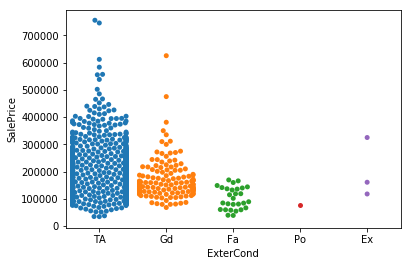

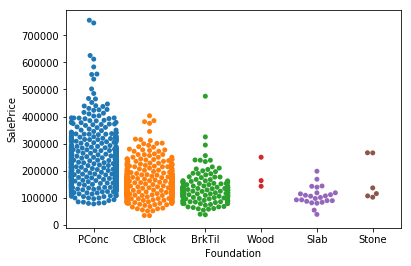

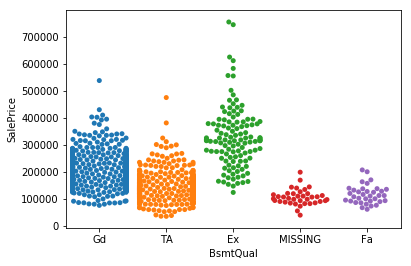

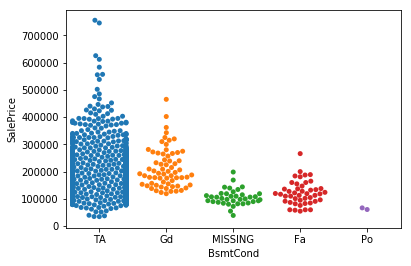

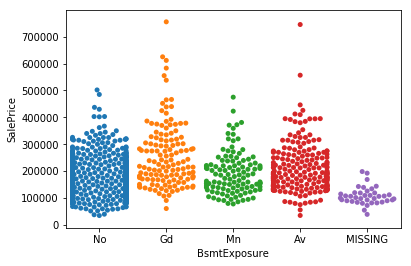

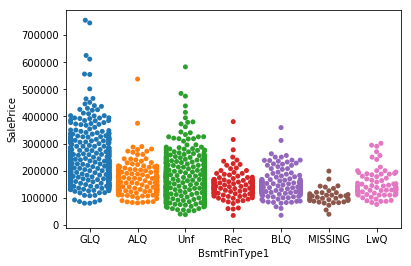

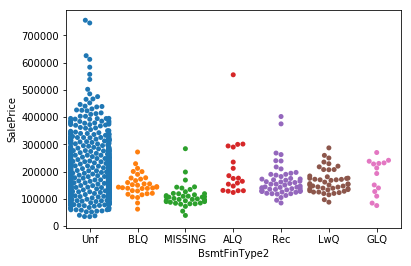

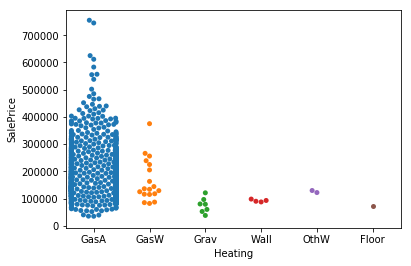

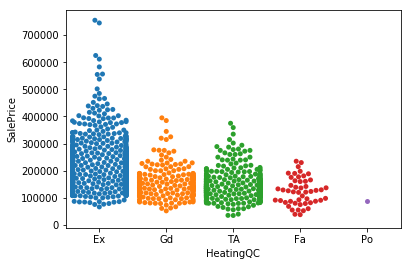

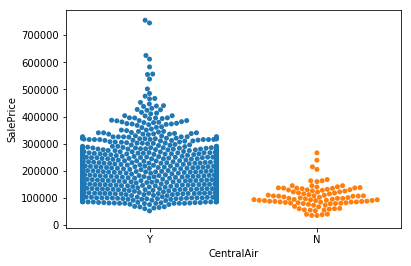

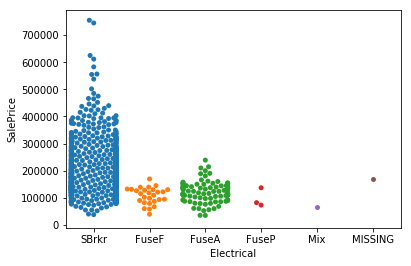

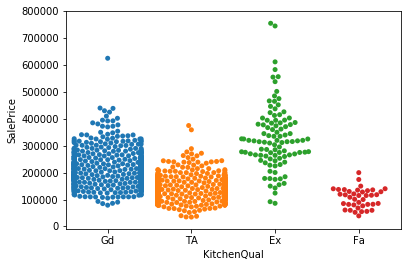

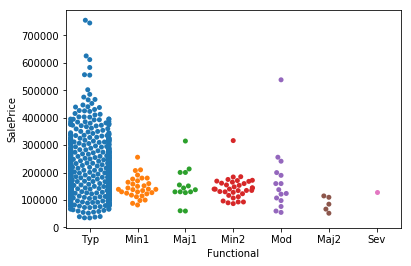

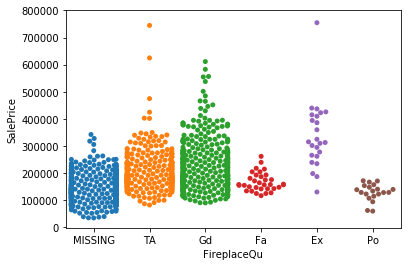

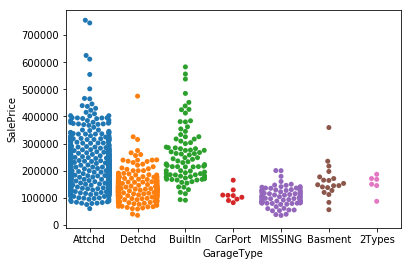

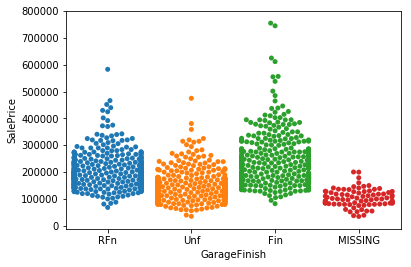

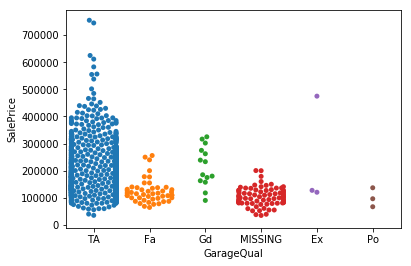

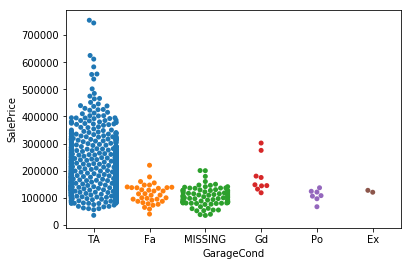

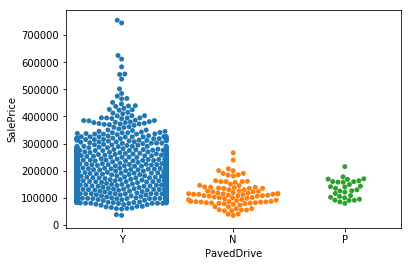

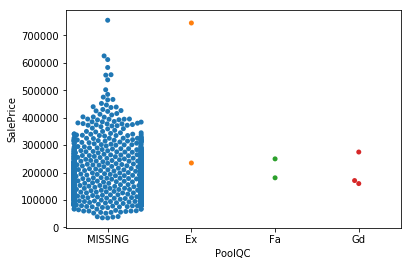

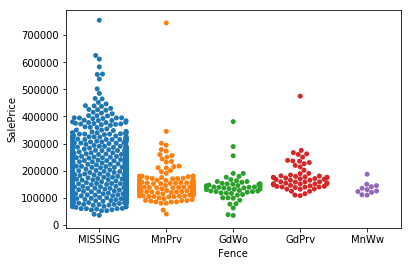

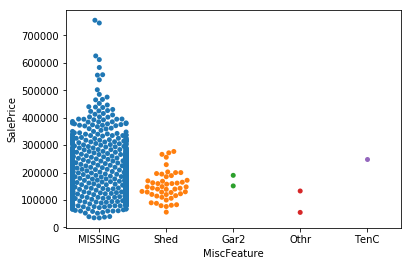

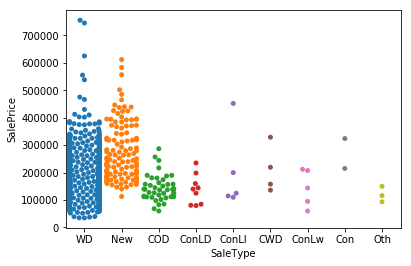

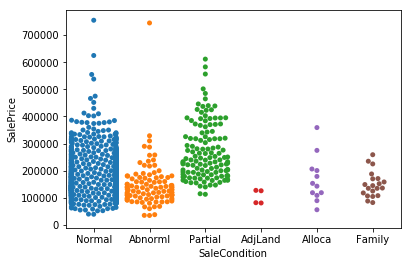

In [9]:
for i,col in enumerate(categors):
    plt.figure(i)
    sns.swarmplot(x=col, y="SalePrice", data=train);

#### Feature Engineering

In [10]:
# del(train2)
train2 = train.copy(deep=True)

Creating a function (Feats) that will allow for data processing replication with another dataset will be very useful here - Eventually, I have to process the Test data for making our submission predictions in the same way that we process Train.

The code below for converting ordered categorical variables is a little sloppy, but I can't figure out how to get the looping right.

In [11]:
def Feats(df):
    
    # create 1/0 indicators for categories that may be useful to have on their own.
    df['MSZoningFV'] = (df['MSZoning'] == 'FV')*1
    df['RoofStyleHip'] = (df['RoofStyle'] == 'Hip')*1
    df['MiscFeatureShed'] = (df['MiscFeature'] == 'Shed')*1
    df['CentralAirY'] = (df['CentralAir'] == 'Y')*1
    df['Garage'] = (df['GarageQual'] != float('nan'))*1
    df['CulDSac'] = (df['LotConfig'] == 'CulDSac')*1
    df['Fireplace'] = (df['Fireplaces'] > 0)*1
    df['WoodDeck'] = (df['WoodDeckSF'] > 0)*1
    df['OpenPorch'] = (df['OpenPorchSF'] > 0)*1
    df['EnclosedPorch'] = (df['EnclosedPorch'] > 0)*1
    df['ScreenPorch'] = (df['ScreenPorch'] > 0)*1
    df['Fence'] = (df['Fence'] != float('nan'))*1
    df['NewSaleType'] = (df['SaleType'] == 'New')*1
    df['ExtVinyl'] = (df['Exterior1st'] == 'VinylSd')*1
    
    # combine some features - ie, basement square footage, total number of bathrooms.
    df['BsmtSF'] = df['BsmtFinSF2'] + df['BsmtUnfSF'] + df['BsmtFinSF1']
    df['BathTotal'] = df['BsmtFullBath'] + df['BsmtHalfBath'] + df['FullBath'] + df['HalfBath']
    df['KitchenGT1'] = (df['KitchenAbvGr'] > 1)*1
    df['FlrSF'] = df['1stFlrSF'] + df['2ndFlrSF'] + df['TotalBsmtSF']
    
    # turn ordered categorical variables into ordered numeric variables.
    
    d1 = {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'MISSING':0,'NA':0}
    numercats1 = ['ExterQual','ExterCond','BsmtQual','BsmtCond','HeatingQC',
                 'KitchenQual','FireplaceQu']
    
    for col in numercats1:
        df[col+str('Numers')] = df[col].map(d1)
    
    d2 = {'Gd':3,'Av':2,'Mn':1,'No':0,'MISSING':0}
    numercats2 = ['BsmtExposure']
    
    for col in numercats2:
        df[col+str('Numers')] = df[col].map(d2)
      
    d3 = {'Fin':3,'RFn':2,'Unf':1,'NA':0,'MISSING':0}
    numercats3 = ['GarageFinish']
     
    for col in numercats3:
        df[col+str('Numers')] = df[col].map(d3)
        
    # create dummy variables. ie, I want a separate variable for EACH neighborhood listed in Neighborhood.
    
    dumcols = ['Neighborhood','MasVnrType','Foundation','BsmtFinType1','GarageType','PavedDrive','SaleCondition','Condition1',
              'BldgType','HouseStyle']
    
    df = pd.get_dummies(df,columns=dumcols,drop_first=True)
    
    # drop columns that we've turned into something else and won't be using going forward.
    
    df = df.drop(columns=['MSZoning','RoofStyle','MiscFeature','CentralAir','GarageQual','Street',
                          'Alley','LotShape','LandContour','Utilities','LandSlope','Condition2',
                          'RoofMatl','BsmtFinType2','Functional','LotConfig','MSSubClass',
                     'Heating','Electrical','PoolQC','GarageCond','LotFrontage','LotArea',
                         'YearRemodAdd','MasVnrArea','BsmtFinSF2','BsmtUnfSF','BsmtFinSF1',
                         'LowQualFinSF','GarageYrBlt','3SsnPorch','PoolArea','MiscVal','MoSold',
                         'YrSold','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','KitchenAbvGr',
                         '1stFlrSF','2ndFlrSF','TotalBsmtSF','Fireplaces','WoodDeckSF','OpenPorchSF',
                         'SaleType','Exterior2nd','Exterior1st'])
    df = df.drop(columns=numercats1)
    df = df.drop(columns=numercats2)
    df = df.drop(columns=numercats3)
    
    # replace spaces and decimal points in the column names.
    df.columns = df.columns.str.replace('\s+', '_')
    df.columns = df.columns.str.replace('.', '')
    
    return df

In [12]:
train3 = Feats(train2)

Check out the results of our processing...

In [13]:
fullprint(train3.head())

Id  OverallQual  OverallCond  YearBuilt  GrLivArea  BedroomAbvGr  \
0   1            7            5       2003       1710             3   
1   2            6            8       1976       1262             3   
2   3            7            5       2001       1786             3   
3   4            7            5       1915       1717             3   
4   5            8            5       2000       2198             4   

   TotRmsAbvGrd  GarageCars  GarageArea  EnclosedPorch  ScreenPorch  Fence  \
0             8           2         548              0            0      1   
1             6           2         460              0            0      1   
2             6           2         608              0            0      1   
3             7           3         642              1            0      1   
4             9           3         836              0            0      1   

   SalePrice  MSZoningFV  RoofStyleHip  MiscFeatureShed  CentralAirY  Garage  \
0     208500           0             0                0            1       1   
1     181500           0             0                0            1       1   
2     223500           0             0                0            1       1   
3     140000           0             0                0            1       1   
4     250000           0             0                0            1       1   

   CulDSac  Fireplace  WoodDeck  OpenPorch  NewSaleType  ExtVinyl  BsmtSF  \
0        0          0         0          1            0         1     856   
1        0          1         1          0            0         0    1262   
2        0          1         0          1            0         1     920   
3        0          1         0          1            0         0     756   
4        0          1         1          1            0         1    1145   

   BathTotal  KitchenGT1  FlrSF  ExterQualNumers  ExterCondNumers  \
0          4           0   2566                4                3   
1          3           0   2524                3                3   
2          4           0   2706                4                3   
3          2           0   2473                3                3   
4          4           0   3343                4                3   

   BsmtQualNumers  BsmtCondNumers  HeatingQCNumers  KitchenQualNumers  \
0               4               3                5                  4   
1               4               3                5                  3   
2               4               3                5                  4   
3               3               4                4                  4   
4               4               3                5                  4   

   FireplaceQuNumers  BsmtExposureNumers  GarageFinishNumers  \
0                  0                   0                   2   
1                  3                   3                   2   
2                  3                   1                   2   
3                  4                   0                   1   
4                  3                   2                   2   

   Neighborhood_Blueste  Neighborhood_BrDale  Neighborhood_BrkSide  \
0                     0                    0                     0   
1                     0                    0                     0   
2                     0                    0                     0   
3                     0                    0                     0   
4                     0                    0                     0   

   Neighborhood_ClearCr  Neighborhood_CollgCr  Neighborhood_Crawfor  \
0                     0                     1                     0   
1                     0                     0                     0   
2                     0                     1                     0   
3                     0                     0                     1   
4                     0                     0                     0   

   Neighborhood_Edwards  Neighborhood_Gilbert  Neighborhood_IDOTRR  \
0     

I had incorrectly coded BsmtExposureNumers, which left NaNs. Leaving the code in below in case I need to do something like this in the future.

In [142]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', 3):
#     display(np.isnan(train3).any())
#     display(np.isinf(train3).any())
#     display(np.float64(train3).any())
    
# train3["BsmtExposureNumers"].value_counts(dropna=False)
# fullprint(train3.head())

Used this as a guide for VIF: [Variance Inflation Factor](https://etav.github.io/python/vif_factor_python.html)

In [14]:
def VIFchk(df):
    numers=[i for i in df if i not in ["SalePrice"]]
    features = "+".join(numers)
    # fullprint(features)
    y, X = dmatrices('SalePrice ~' + features, df, return_type='dataframe')
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["features"] = X.columns
    vif2 = vif.sort_values('VIF Factor',ascending=False)
    fullprint(vif2.round(1).head(10))
    
VIFchk(train3)

C:\Users\laure\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1386: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


VIF Factor               features
27       498.0                  FlrSF
5        209.6              GrLivArea
24       147.9                 BsmtSF
76        68.6      GarageType_Attchd
80        55.2      GarageType_Detchd
88        41.6  SaleCondition_Partial
22        40.5            NewSaleType
63        27.1        MasVnrType_None
61        24.4     MasVnrType_BrkFace
48        18.7     Neighborhood_NAmes

Based on VIF results:

In [15]:
train4 = train3.drop(columns=["GrLivArea","BsmtSF","NewSaleType","GarageType_Detchd","MasVnrType_None","Fireplace"])
VIFchk(train4)

C:\Users\laure\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1386: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


VIF Factor              features
44        18.6    Neighborhood_NAmes
49        12.1  Neighborhood_OldTown
37        11.9  Neighborhood_CollgCr
53        11.3  Neighborhood_Somerst
4         10.8             YearBuilt
39         9.6  Neighborhood_Edwards
68         8.0  BsmtFinType1_MISSING
51         7.6   Neighborhood_Sawyer
40         7.4  Neighborhood_Gilbert
46         7.4   Neighborhood_NWAmes

I should probably eventually rethink the way I'm handling Neigborhood.

In [17]:
fullprint(train4.head())

Id  OverallQual  OverallCond  YearBuilt  BedroomAbvGr  TotRmsAbvGrd  \
0   1            7            5       2003             3             8   
1   2            6            8       1976             3             6   
2   3            7            5       2001             3             6   
3   4            7            5       1915             3             7   
4   5            8            5       2000             4             9   

   GarageCars  GarageArea  EnclosedPorch  ScreenPorch  Fence  SalePrice  \
0           2         548              0            0      1     208500   
1           2         460              0            0      1     181500   
2           2         608              0            0      1     223500   
3           3         642              1            0      1     140000   
4           3         836              0            0      1     250000   

   MSZoningFV  RoofStyleHip  MiscFeatureShed  CentralAirY  Garage  CulDSac  \
0           0             0                0            1       1        0   
1           0             0                0            1       1        0   
2           0             0                0            1       1        0   
3           0             0                0            1       1        0   
4           0             0                0            1       1        0   

   WoodDeck  OpenPorch  ExtVinyl  BathTotal  KitchenGT1  FlrSF  \
0         0          1         1          4           0   2566   
1         1          0         0          3           0   2524   
2         0          1         1          4           0   2706   
3         0          1         0          2           0   2473   
4         1          1         1          4           0   3343   

   ExterQualNumers  ExterCondNumers  BsmtQualNumers  BsmtCondNumers  \
0                4                3               4               3   
1                3                3               4               3   
2                4                3               4               3   
3                3                3               3               4   
4                4                3               4               3   

   HeatingQCNumers  KitchenQualNumers  FireplaceQuNumers  BsmtExposureNumers  \
0                5                  4                  0                   0   
1                5                  3                  3                   3   
2                5                  4                  3                   1   
3                4                  4                  4                   0   
4                5                  4                  3                   2   

   GarageFinishNumers  Neighborhood_Blueste  Neighborhood_BrDale  \
0                   2                     0                    0   
1                   2                     0                    0   
2                   2                     0                    0   
3                   1                     0                    0   
4                   2                     0                    0   

   Neighborhood_BrkSide  Neighborhood_ClearCr  Neighborhood_CollgCr  \
0                     0                     0                     1   
1                     0                     0                     0   
2                     0                     0                     1   
3                     0                     0                     0   
4                     0                     0                     0   

   Neighborhood_Crawfor  Neighborhood_Edwards  Neighborhood_Gilbert  \
0                     0                     0                     0   
1                     0                     0                     0   
2                     0                     0                     0   
3                     1                     0                     0   
4                     0                     0                     0   

   Neighborhood_IDOTRR  Neighborhood_MeadowV  Neighborhood_Mitchel  \


Below is a function I wrote to create a correlation matrix. I don't actually use it in this program, but in case you wanted to try it out for yourself, it's here.

In [15]:
def plot_corr(df,size=20):
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);

I did some tinkering below before I decided to just include everything. I tried only including features that had a correlational value less than -.4 or greater than .4, greater than .6... Didn't get optimal results. So I ended up throwing everything in the dataset (with the exception of SalePrice and Id) into the model.

In [18]:
# corr = train4.corr()
# corrtot = corr['SalePrice']
# corrsub = corr[np.logical_or(corr['SalePrice']>.4,corr['SalePrice']<-.4)]
# corrsub = corr[corr['SalePrice']>.6]
# corrlist=corrsub.index.values.tolist()
# corrlist = [x for x in corrlist if x != 'SalePrice']
# corrlist

# everything but the kitchen sink
sink = train4.drop(columns=['SalePrice','Id'])
sink.head()
corrlist = sink.columns.values.tolist()

# corrlist

RMSLE is the scoring method Kaggle uses for this competition. The closer to zero, the better. The function below makes it easy to calculate RMSLE.

In [19]:
def rmsle(y,y_pred):
    assert len(y) == len(y_pred)
    return np.sqrt(np.mean(np.power(np.log1p(y)-np.log1p(y_pred), 2)))

In [20]:
y = train4["SalePrice"]
X1 = train4[corrlist]

X_train, X_test, y_train, y_test = train_test_split(X1,y,test_size=.3,random_state=25)

# easy way to loop through multiple models.
def modrun(model):
    linr = model
    linr.fit(X_train, y_train)
    y_pred = linr.predict(X_test)
    print(rmsle(y_test,y_pred))

In [21]:
modrun(LinearRegression(normalize=True))
modrun(RandomForestRegressor(n_estimators = 50, random_state = 25))

0.16512555802292
0.1469186066412791


Check to see if model results improve with cross validation.

In [22]:
def CrossVal(model):
    linr = model
    linr2 = linr.fit(X_train, y_train)
    # scores = cross_val_score(linr, X1, y, cv=6)
    # print(scores)
    preds = cross_val_predict(linr2, X1, y, cv=6)
    print(rmsle(y,preds))

CrossVal(LinearRegression(normalize=True))
CrossVal(RandomForestRegressor(n_estimators = 50, random_state = 25))

0.16132491758246337
0.14126960081258352


6 folds provides optimal results for linear regression and random forest regressor.

#### Prior to accounting for VIF:

Linear regression
* Full set of variables: 0.1646
* Correlation > .4: 0.2194
* Correlation > .6: 0.2593

Random forest regressor
* Full set of variables: 0.1427
* Correlation > .4: 0.1539
* Correlation > .6: 0.1657

#### After accounting for VIF, full set of variables:
* Linear regression: 0.1614
* Random forest regressor: 0.1419

Beyond this point is just me tinkering with hyperparameter tuning.
------------------------

Now we'll try hyperparameter tuning. [With help from this guy.](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74)

In [64]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestRegressor()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=25, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  7.1min finished


In [65]:
preds = rf_random.predict(X_test)
print(rmsle(y_test,preds))

0.15089795188672467


In [66]:
rf_random.best_params_

{'bootstrap': False,
 'max_depth': 50,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1800}

In [69]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False],
    'max_depth': [40,50,60],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1,2],
    'min_samples_split': [2,3],
    'n_estimators': [1600,1800,2000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  2.6min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'bootstrap': [False], 'max_depth': [40, 50, 60], 'max_features': ['sqrt'], 'min_samples_leaf': [1, 2], 'min_samples_split': [2, 3], 'n_estimators': [1600, 1800, 2000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [70]:
preds = grid_search.predict(X_test)
print(rmsle(y_test,preds))

0.1510457555788374


In [71]:
grid_search.best_params_

{'bootstrap': False,
 'max_depth': 60,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 2000}

Ok... so hyperparameter tuning didn't improve the model results.